In [4]:
from pathlib import Path
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from data_loader import *

In [2]:
folder1  = Path.cwd().parent / 'Illustris1'
DM_name1 = ['deltaDM_Illustris1_L75_N600.fits', 
            'vx_DM_Illustris1_L75_N600.fits',
            'vy_DM_Illustris1_L75_N600.fits',
            'vz_DM_Illustris1_L75_N600.fits']
ske_name1 = 'spectra_Illustris1_N600_zaxis.npy'

In [3]:
folder3  = Path.cwd().parent / 'Illustris3'
DM_name3 = ['DMdelta_Illustris3_L75_N600_v2.fits', 
            'vx_cic_Illustris3_L75_N600_v2.fits',
            'vy_cic_Illustris3_L75_N600_v2.fits',
            'vz_cic_Illustris3_L75_N600_v2.fits']
ske_name3 = 'spectra_Illustris3_N600_zaxis.npy'

In [4]:
# read in over density field
DM_fits = fits.open(folder1/DM_name1[0])
DM_den1 = DM_fits[0].data + 1
DM_fits.close(); del DM_fits

# basic paramters
DM_pix  = len(DM_den1)
DM_len  = 75*1000 # in kpc/h
DM_reso = DM_len / DM_pix # in kpc/h

# read in vx field
DM_vx_fits = fits.open(folder1/DM_name1[1])
DM_vx1 = DM_vx_fits[0].data
DM_vx_fits.close(); del DM_vx_fits

# read in vy field
DM_vy_fits = fits.open(folder1/DM_name1[2])
DM_vy1 = DM_vy_fits[0].data
DM_vy_fits.close(); del DM_vy_fits

# read in vz field
DM_vz_fits = fits.open(folder1/DM_name1[3])
DM_vz1 = DM_vz_fits[0].data
DM_vz_fits.close(); del DM_vz_fits

In [5]:
# read in over density field
DM_fits = fits.open(folder3/DM_name3[0])
DM_den3 = DM_fits[0].data + 1
DM_fits.close(); del DM_fits

# basic paramters
DM_pix  = len(DM_den3)
DM_len  = 75*1000 # in kpc/h
DM_reso = DM_len / DM_pix # in kpc/h

# read in vx field
DM_vx_fits = fits.open(folder3/DM_name3[1])
DM_vx3 = DM_vx_fits[0].data
DM_vx_fits.close(); del DM_vx_fits

# read in vy field
DM_vy_fits = fits.open(folder3/DM_name3[2])
DM_vy3 = DM_vy_fits[0].data
DM_vy_fits.close(); del DM_vy_fits

# read in vz field
DM_vz_fits = fits.open(folder3/DM_name3[3])
DM_vz3 = DM_vz_fits[0].data
DM_vz_fits.close(); del DM_vz_fits

In [6]:
(np.linalg.norm(([DM_vx1, DM_vy1, DM_vz1]), axis=0)*(DM_den1)).mean() / DM_den1.mean()

247.80524

In [7]:
(np.linalg.norm(([DM_vx3, DM_vy3, DM_vz3]), axis=0)*(DM_den3)).mean() / DM_den3.mean()

247.95488

In [6]:
ske1 = np.load(folder1/ske_name1).reshape(600,600,600)
ske3 = np.load(folder3/ske_name3).reshape(600,600,600)

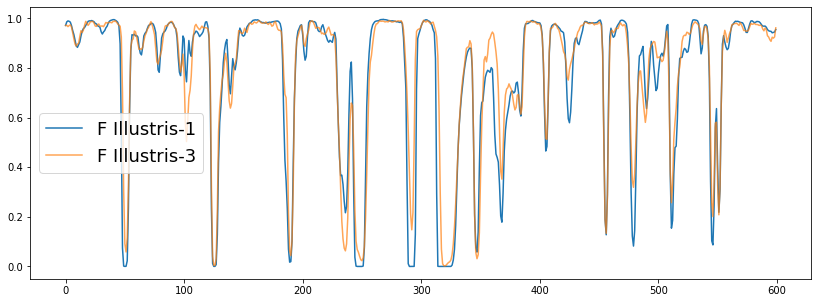

In [60]:
plt.figure(figsize=(14,5))
ii = np.random.randint(0, 600)
jj = np.random.randint(0, 600)
plt.plot(np.exp(-ske1[ii, jj, :]), label='F Illustris-1')
plt.plot(np.exp(-ske3[ii, jj, :]), label='F Illustris-3', alpha=0.7)
plt.legend(fontsize=18)

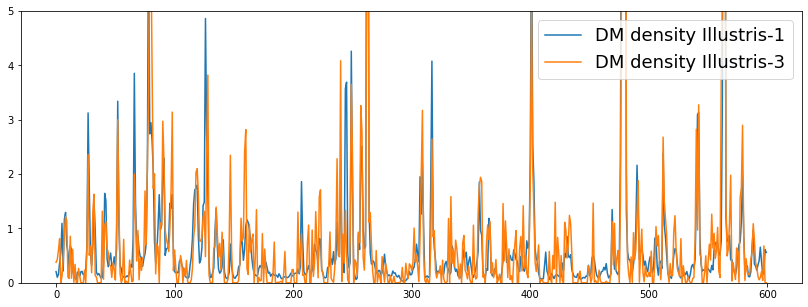

In [13]:
plt.figure(figsize=(14,5))
ii = np.random.randint(0, 600)
jj = np.random.randint(0, 600)
plt.plot(DM_den1[ii, jj, :], label='DM density Illustris-1')
plt.plot(DM_den3[ii, jj, :], label='DM density Illustris-3')
plt.ylim([0, 5]);
plt.legend(fontsize=18)

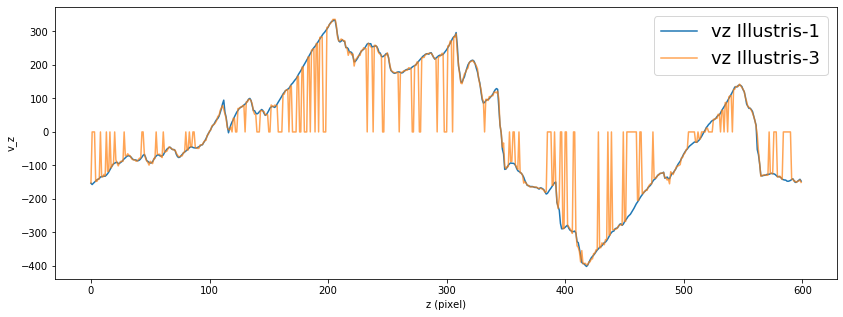

In [11]:
plt.figure(figsize=(14,5))
ii = np.random.randint(0, 600)
jj = np.random.randint(0, 600)
plt.plot(DM_vz1[ii, jj, :], label='vz Illustris-1')
plt.plot(DM_vz3[ii, jj, :], label='vz Illustris-3', alpha=0.7)
plt.xlabel('z (pixel)')
plt.ylabel('v_z')
plt.legend(fontsize=18)

In [1]:
from pathlib import Path
import time
import numpy as np
import torch

from data_loader import *
#from model import *
from train import *
from val import *

# Path and data file name
folder  = Path.cwd().parent / 'Illustris1'
DM_name = ['deltaDM_Illustris1_L75_N600.fits', 
            'vx_DM_Illustris1_L75_N600.fits',
            'vy_DM_Illustris1_L75_N600.fits',
            'vz_DM_Illustris1_L75_N600.fits']
ske_name = 'spectra_Illustris1_N600_zaxis.npy'



# hyper parameters
train_len  = 6000 # number of tau blocks
val_len    = 200  # number of tau blocks
test_len   = 200  # number of skewers
train_insize = np.array([15, 15, 71]) # x, y, z respctively
train_ousize = np.array([5, 5, 5]) # x, y, z respctively
batch_size = 50
learning_rate = 0.001
num_epochs = 20
localtime = time.localtime()
if ~(train_insize%2).all():
    raise ValueError('train size cannot be even.')

# pre-process
def pre_proc(tau, block):
    '''log(tau)'''
    bln = np.ones(len(block), dtype='bool')
    tau = np.log(tau)
    return (tau[bln],  block[bln])

In [2]:
# device used to train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device=device.index))

Using device: Quadro P6000


In [152]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.distributions import Categorical

ONEOVERSQRT2PI = float(1.0 / np.sqrt(2*np.pi))


def narrow_tensor(tensorA, tensorB):
    '''
    to narrow tensorA to be like tensorB by deleting border elments 
    '''
    Ashape = np.array(tensorA.shape[2:5])
    Bshape = np.array(tensorB.shape[2:5])
    dx, dy, dz = ((Ashape-Bshape)//2)
    tensorA = tensorA[:,:,dx:Ashape[0]-dx,dy:Ashape[1]-dy,dz:Ashape[2]-dz]
    #print(tensorA.shape, tensorB.shape)
    return tensorA

#basic convolutional block
def conv3x3(in_channels, out_channels, stride=1, kernel_size=(3,3,3)):
    return nn.Conv3d(in_channels, out_channels, kernel_size, 
                     stride=stride, padding=0, bias=False)

#basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        
        residual = narrow_tensor(residual, out)
        out += residual
        out = self.relu(out)
        
        return out

#The SkeNet!
layers= [2, 1]
class SkeNet(torch.nn.Module):
    def __init__(self, block, layers = layers, num_classes=1):
        super(SkeNet, self).__init__()
        self.in_channels = 16
        self.conv1 = conv3x3(4, 16)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], stride=1)
        self.conv2 = conv3x3(32, 16, kernel_size=(1,1,43))
        self.conv3 = conv3x3(16, 8)
        self.bn = torch.nn.BatchNorm3d(16)
        self.relu = torch.nn.ReLU(inplace=True)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        kernel_size = (1,1,3)
        if (stride != 1) or (self.in_channels != out_channels):
            kernel_size=(1,1,13)
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride, kernel_size=kernel_size),
                torch.nn.BatchNorm3d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out) #residual layer 1
        out = self.layer2(out) #residual layer 2
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)

        return out.squeeze(1)

    
class MDN(nn.Module):
    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(in_features, out_features*num_gaussians)
        self.mu = nn.Linear(in_features, out_features*num_gaussians)

    def forward(self, x):
        x  = x.view(-1, self.in_features)
        pi = self.pi(x)
        sigma = torch.exp(self.sigma(x))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(x)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        
        return pi, sigma, mu
        
        
def gaussian_probability(sigma, mu, target):
    
    target = target.view(sigma.shape[0], sigma.shape[1], sigma.shape[2])
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((target - mu) / sigma)**2) / sigma
    
    return torch.prod(ret, dim=2)


def mdn_loss(pi, sigma, mu, target):
    
    prob = pi * gaussian_probability(sigma, mu, target)
    nll = -torch.log(torch.sum(prob, dim=1))
    
    return torch.mean(nll)

def sample(pi, sigma, mu):
    
    categorical = Categorical(pi)
    pis = list(categorical.sample().data)
    sample = Variable(sigma.data.new(sigma.size(0), sigma.size(2)).normal_())
    for i, idx in enumerate(pis):
        sample[i] = sample[i].mul(sigma[i,idx]).add(mu[i,idx])
    return sample

In [154]:
model = nn.Sequential(
    SkeNet(ResidualBlock,layers=layers),
    MDN(8, 1, 4)
    ).float()

In [159]:
inputs = torch.ones(size=(2,4,15,15,73))
target = torch.ones(size=(2,5,5,5, 4))

In [163]:
target[:,:,:,:,0].shape

torch.Size([2, 5, 5, 5])

In [156]:
pi, sigma, mu = model(inputs)

In [158]:
target.reshape()

AttributeError: 'Tensor' object has no attribute 'sigma'

In [129]:
sigma.shape

torch.Size([250, 3, 1])

In [147]:
mdn_loss(pi, sigma, mu, target)

tensor(1.3093, grad_fn=<MeanBackward1>)

In [117]:
gaussian_probability(sigma, mu, target).shape

torch.Size([250, 3])

In [148]:
samples = sample(pi, sigma, mu)

In [170]:
samples.squeeze().shape

torch.Size([250])

In [151]:
samples.reshape(2, train_ousize[0], train_ousize[1], train_ousize[2]).shape

torch.Size([2, 5, 5, 5])

In [116]:
pi.shape

torch.Size([250, 3])

In [29]:
nn.Tanh

torch.nn.modules.activation.Tanh

In [ ]:
# load model
model = get_residual_network().float().to(device)
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)